In [11]:
import torch
import torchvision
import datasets, networks, sampling, evaluation
import matplotlib.pyplot as plt
from torch import nn, optim

In [12]:
# HYPERPARAMETERS
num_epochs = 10 


# TODO Select a batch size.
batch_size = 64


# TODO Select a learning rate.
lr= 1e-6


num_units=2000
num_layer=4

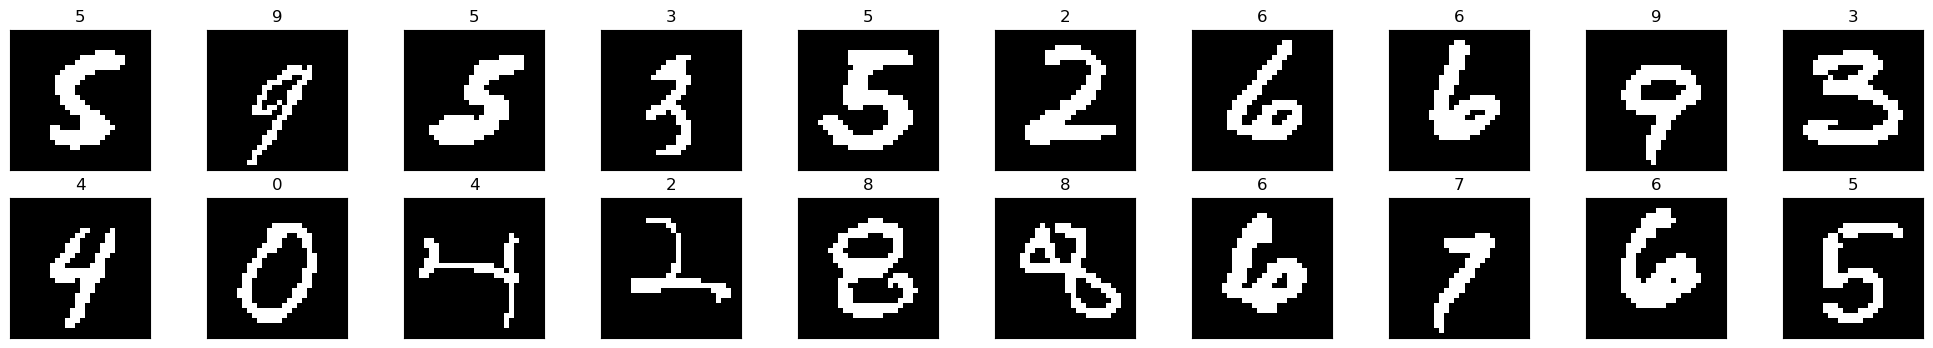

In [13]:
# Create Dataset/Data Loaders and visualize Dataset
Ds = datasets.Dataset('mnist', batch_size=batch_size)
training_data = Ds.get_train_data_loader()
test_data = Ds.get_test_data_loader()

Ds.visualize_dataset(training_data)


ordering=range(1,785) 

Using device: cuda:0
Epoch:   1/ 10, Batch     1, Loss: 0.7032
Epoch:   1/ 10, Batch   101, Loss: 0.6969
Epoch:   1/ 10, Batch   201, Loss: 0.6844
Epoch:   1/ 10, Batch   301, Loss: 0.6725
Epoch:   1/ 10, Batch   401, Loss: 0.6610
Epoch:   1/ 10, Batch   501, Loss: 0.6500
Epoch:   1/ 10, Batch   601, Loss: 0.6391
Epoch:   1/ 10, Batch   701, Loss: 0.6289
Epoch:   1/ 10, Batch   801, Loss: 0.6189
Epoch:   1/ 10, Batch   901, Loss: 0.6088
-----------------------------------------
Epoch:   1 took 10.12s
Epoch:   1, Test Loss: 0.6023
-----------------------------------------
tensor([[0.4974, 0.4970, 0.5014,  ..., 0.3264, 0.4345, 0.3844],
        [0.4974, 0.4994, 0.4990,  ..., 0.3504, 0.3182, 0.3641],
        [0.4974, 0.4978, 0.5019,  ..., 0.4976, 0.4031, 0.3822],
        ...,
        [0.4974, 0.4971, 0.5015,  ..., 0.4206, 0.4361, 0.3369],
        [0.4974, 0.4970, 0.4994,  ..., 0.3929, 0.3237, 0.4238],
        [0.4974, 0.4973, 0.5017,  ..., 0.3664, 0.4157, 0.3666]],
       device='cuda:0', 

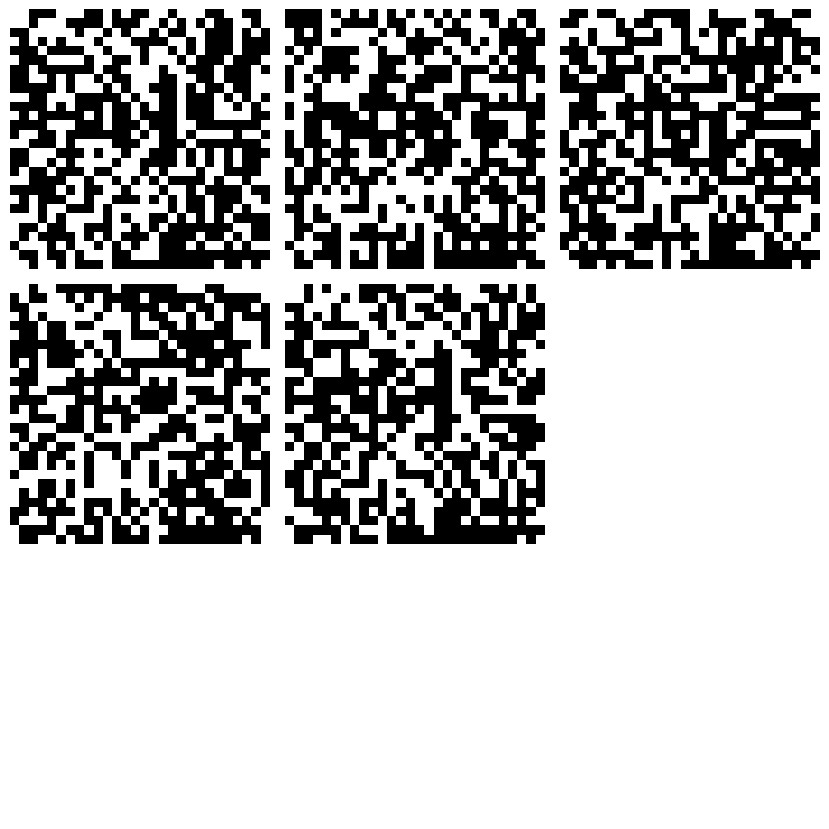

Epoch:   2/ 10, Batch     1, Loss: 0.5987
Epoch:   2/ 10, Batch   101, Loss: 0.5961
Epoch:   2/ 10, Batch   201, Loss: 0.5874
Epoch:   2/ 10, Batch   301, Loss: 0.5781
Epoch:   2/ 10, Batch   401, Loss: 0.5695
Epoch:   2/ 10, Batch   501, Loss: 0.5611
Epoch:   2/ 10, Batch   601, Loss: 0.5531
Epoch:   2/ 10, Batch   701, Loss: 0.5454
Epoch:   2/ 10, Batch   801, Loss: 0.5380
Epoch:   2/ 10, Batch   901, Loss: 0.5306
-----------------------------------------
Epoch:   2 took 9.99s
Epoch:   2, Test Loss: 0.5260
-----------------------------------------
tensor([[0.4972, 0.4967, 0.4977,  ..., 0.3367, 0.2568, 0.2694],
        [0.4972, 0.4975, 0.5016,  ..., 0.2414, 0.1929, 0.3671],
        [0.4972, 0.4988, 0.5023,  ..., 0.1758, 0.2619, 0.1924],
        ...,
        [0.4972, 0.4968, 0.5002,  ..., 0.2486, 0.1769, 0.3356],
        [0.4972, 0.4967, 0.4985,  ..., 0.2900, 0.2653, 0.2097],
        [0.4972, 0.4974, 0.4971,  ..., 0.2807, 0.2498, 0.2875]],
       device='cuda:0', grad_fn=<SigmoidBackwa

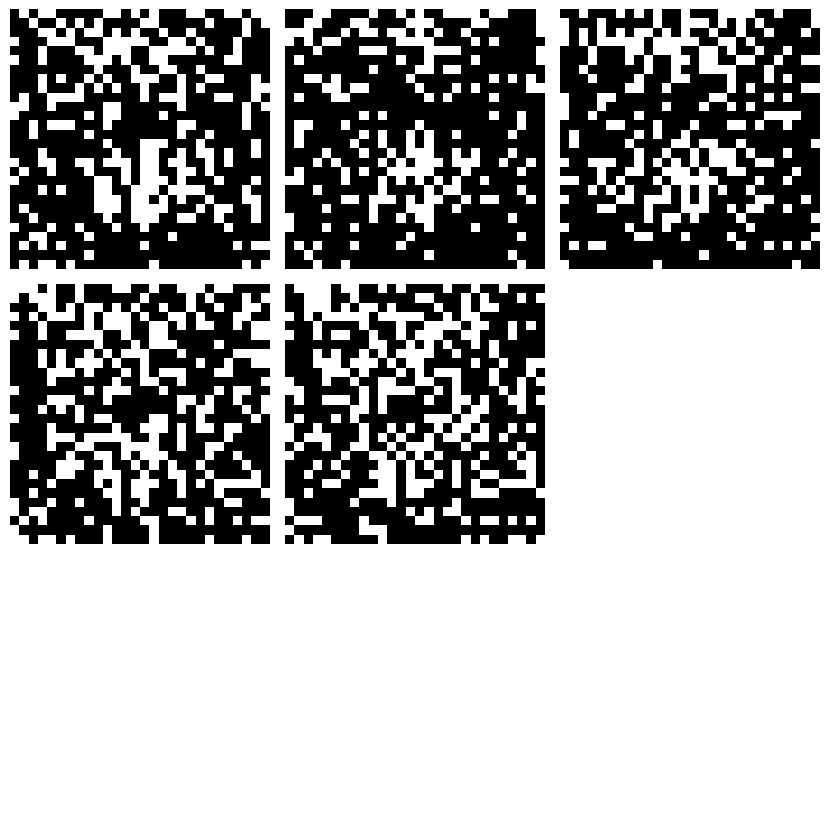

Epoch:   3/ 10, Batch     1, Loss: 0.5230
Epoch:   3/ 10, Batch   101, Loss: 0.5204
Epoch:   3/ 10, Batch   201, Loss: 0.5138
Epoch:   3/ 10, Batch   301, Loss: 0.5070
Epoch:   3/ 10, Batch   401, Loss: 0.5009
Epoch:   3/ 10, Batch   501, Loss: 0.4948
Epoch:   3/ 10, Batch   601, Loss: 0.4887
Epoch:   3/ 10, Batch   701, Loss: 0.4825
Epoch:   3/ 10, Batch   801, Loss: 0.4771
Epoch:   3/ 10, Batch   901, Loss: 0.4714
-----------------------------------------
Epoch:   3 took 9.78s
Epoch:   3, Test Loss: 0.4668
-----------------------------------------
tensor([[0.4970, 0.4966, 0.4974,  ..., 0.2110, 0.2186, 0.2547],
        [0.4970, 0.4965, 0.5007,  ..., 0.2043, 0.1600, 0.1523],
        [0.4970, 0.4978, 0.5016,  ..., 0.1614, 0.1372, 0.2077],
        ...,
        [0.4970, 0.4971, 0.5006,  ..., 0.1406, 0.1515, 0.1120],
        [0.4970, 0.4967, 0.4985,  ..., 0.1802, 0.2008, 0.1726],
        [0.4970, 0.4975, 0.5014,  ..., 0.1757, 0.1772, 0.1902]],
       device='cuda:0', grad_fn=<SigmoidBackwa

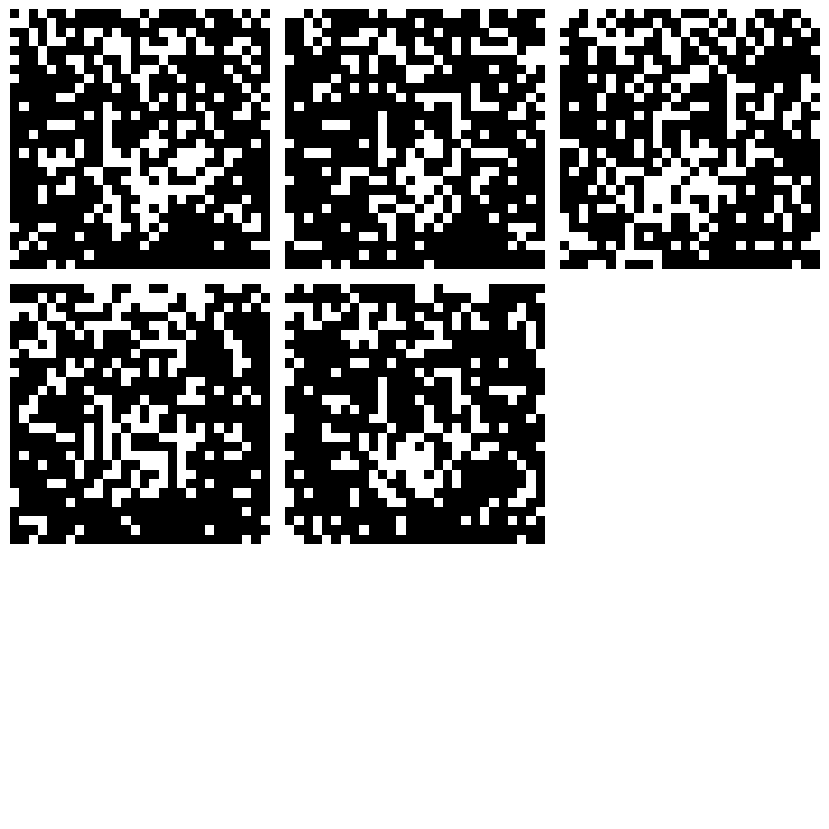

Epoch:   4/ 10, Batch     1, Loss: 0.4666
Epoch:   4/ 10, Batch   101, Loss: 0.4640
Epoch:   4/ 10, Batch   201, Loss: 0.4590
Epoch:   4/ 10, Batch   301, Loss: 0.4539
Epoch:   4/ 10, Batch   401, Loss: 0.4489
Epoch:   4/ 10, Batch   501, Loss: 0.4453
Epoch:   4/ 10, Batch   601, Loss: 0.4401
Epoch:   4/ 10, Batch   701, Loss: 0.4360
Epoch:   4/ 10, Batch   801, Loss: 0.4318
Epoch:   4/ 10, Batch   901, Loss: 0.4272
-----------------------------------------
Epoch:   4 took 10.04s
Epoch:   4, Test Loss: 0.4224
-----------------------------------------
tensor([[0.4967, 0.4963, 0.5007,  ..., 0.1266, 0.2172, 0.1109],
        [0.4967, 0.4963, 0.5007,  ..., 0.1030, 0.0997, 0.0749],
        [0.4967, 0.4971, 0.5010,  ..., 0.1279, 0.0966, 0.1318],
        ...,
        [0.4967, 0.4967, 0.4962,  ..., 0.0928, 0.0584, 0.0910],
        [0.4967, 0.4973, 0.5006,  ..., 0.1062, 0.1441, 0.1942],
        [0.4967, 0.4979, 0.4994,  ..., 0.1439, 0.0924, 0.1117]],
       device='cuda:0', grad_fn=<SigmoidBackw

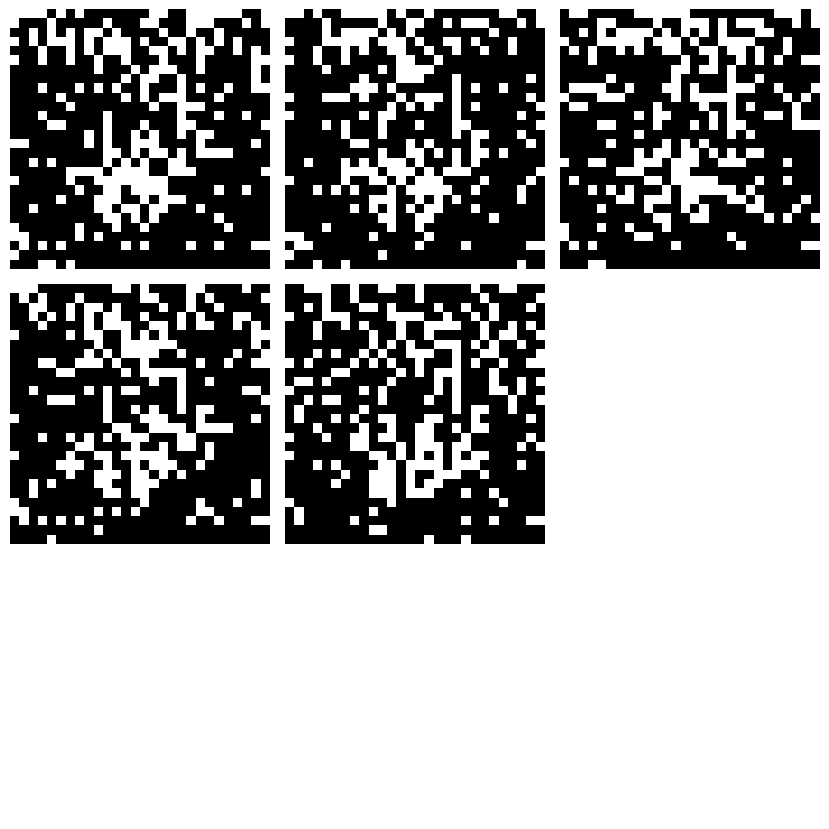

Epoch:   5/ 10, Batch     1, Loss: 0.4197
Epoch:   5/ 10, Batch   101, Loss: 0.4219
Epoch:   5/ 10, Batch   201, Loss: 0.4186
Epoch:   5/ 10, Batch   301, Loss: 0.4148
Epoch:   5/ 10, Batch   401, Loss: 0.4103
Epoch:   5/ 10, Batch   501, Loss: 0.4067
Epoch:   5/ 10, Batch   601, Loss: 0.4034
Epoch:   5/ 10, Batch   701, Loss: 0.3999
Epoch:   5/ 10, Batch   801, Loss: 0.3969
Epoch:   5/ 10, Batch   901, Loss: 0.3931
-----------------------------------------
Epoch:   5 took 9.98s
Epoch:   5, Test Loss: 0.3890
-----------------------------------------
tensor([[0.4965, 0.4960, 0.4997,  ..., 0.1319, 0.1018, 0.1297],
        [0.4965, 0.4960, 0.4940,  ..., 0.0424, 0.0750, 0.0635],
        [0.4965, 0.4960, 0.4991,  ..., 0.0711, 0.0685, 0.0735],
        ...,
        [0.4965, 0.4960, 0.5005,  ..., 0.0880, 0.0894, 0.0740],
        [0.4965, 0.4960, 0.5005,  ..., 0.0756, 0.0775, 0.0595],
        [0.4965, 0.4960, 0.4971,  ..., 0.0903, 0.1115, 0.1072]],
       device='cuda:0', grad_fn=<SigmoidBackwa

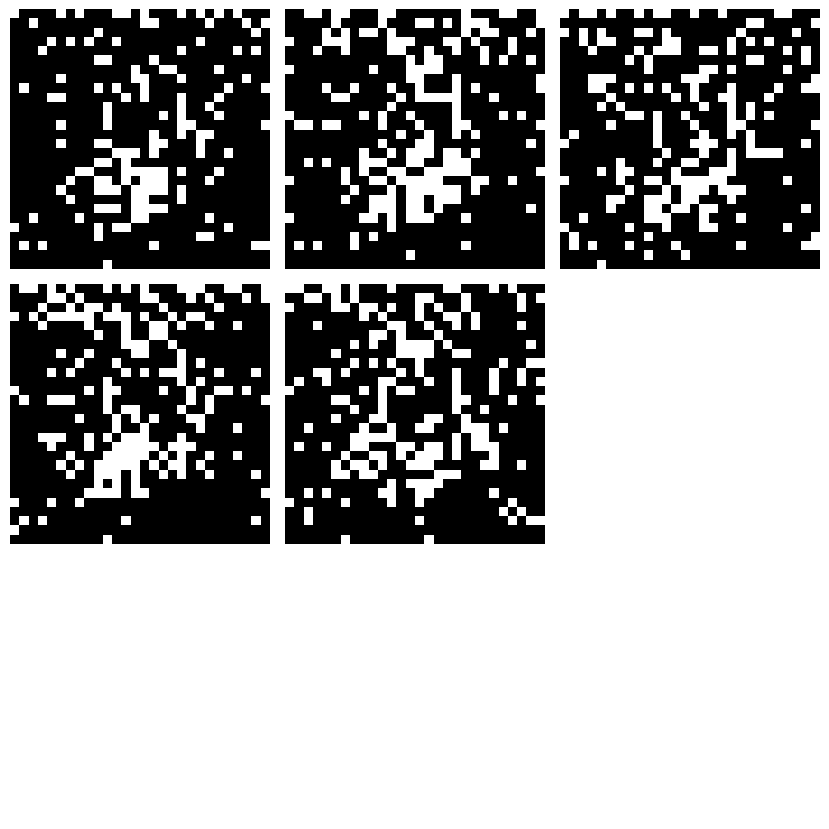

Epoch:   6/ 10, Batch     1, Loss: 0.3913
Epoch:   6/ 10, Batch   101, Loss: 0.3898
Epoch:   6/ 10, Batch   201, Loss: 0.3862
Epoch:   6/ 10, Batch   301, Loss: 0.3833
Epoch:   6/ 10, Batch   401, Loss: 0.3797
Epoch:   6/ 10, Batch   501, Loss: 0.3778
Epoch:   6/ 10, Batch   601, Loss: 0.3751
Epoch:   6/ 10, Batch   701, Loss: 0.3714
Epoch:   6/ 10, Batch   801, Loss: 0.3695
Epoch:   6/ 10, Batch   901, Loss: 0.3669
-----------------------------------------
Epoch:   6 took 10.01s
Epoch:   6, Test Loss: 0.3625
-----------------------------------------
tensor([[0.4963, 0.4948, 0.4915,  ..., 0.0299, 0.0277, 0.0498],
        [0.4963, 0.4960, 0.5001,  ..., 0.0408, 0.0404, 0.0525],
        [0.4963, 0.4959, 0.5002,  ..., 0.0615, 0.0538, 0.0791],
        ...,
        [0.4963, 0.4958, 0.5003,  ..., 0.0698, 0.0755, 0.0446],
        [0.4963, 0.4958, 0.5003,  ..., 0.0353, 0.0399, 0.0538],
        [0.4963, 0.4961, 0.5001,  ..., 0.0317, 0.0319, 0.0299]],
       device='cuda:0', grad_fn=<SigmoidBackw

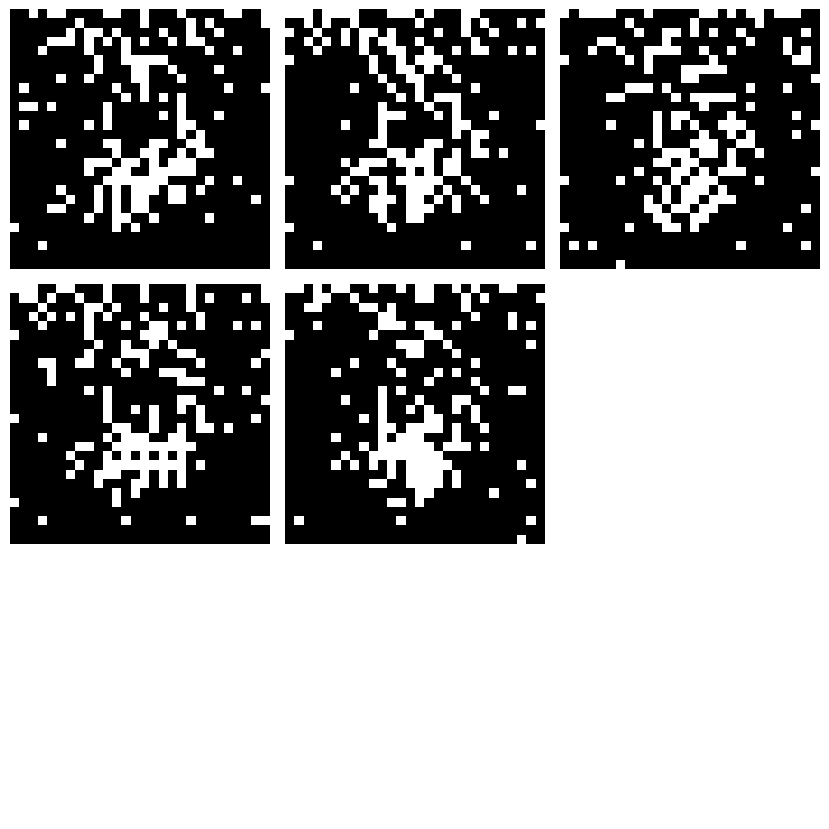

Epoch:   7/ 10, Batch     1, Loss: 0.3512
Epoch:   7/ 10, Batch   101, Loss: 0.3632
Epoch:   7/ 10, Batch   201, Loss: 0.3603
Epoch:   7/ 10, Batch   301, Loss: 0.3575
Epoch:   7/ 10, Batch   401, Loss: 0.3566
Epoch:   7/ 10, Batch   501, Loss: 0.3535
Epoch:   7/ 10, Batch   601, Loss: 0.3520
Epoch:   7/ 10, Batch   701, Loss: 0.3491
Epoch:   7/ 10, Batch   801, Loss: 0.3474
Epoch:   7/ 10, Batch   901, Loss: 0.3453
-----------------------------------------
Epoch:   7 took 10.03s
Epoch:   7, Test Loss: 0.3400
-----------------------------------------
tensor([[0.4960, 0.4957, 0.4996,  ..., 0.0360, 0.0359, 0.0345],
        [0.4960, 0.4956, 0.4966,  ..., 0.0338, 0.0485, 0.0258],
        [0.4960, 0.4956, 0.4942,  ..., 0.0223, 0.0203, 0.0174],
        ...,
        [0.4960, 0.4957, 0.4963,  ..., 0.0279, 0.0320, 0.0240],
        [0.4960, 0.4956, 0.4959,  ..., 0.0573, 0.0309, 0.0394],
        [0.4960, 0.4956, 0.4971,  ..., 0.0610, 0.0625, 0.0602]],
       device='cuda:0', grad_fn=<SigmoidBackw

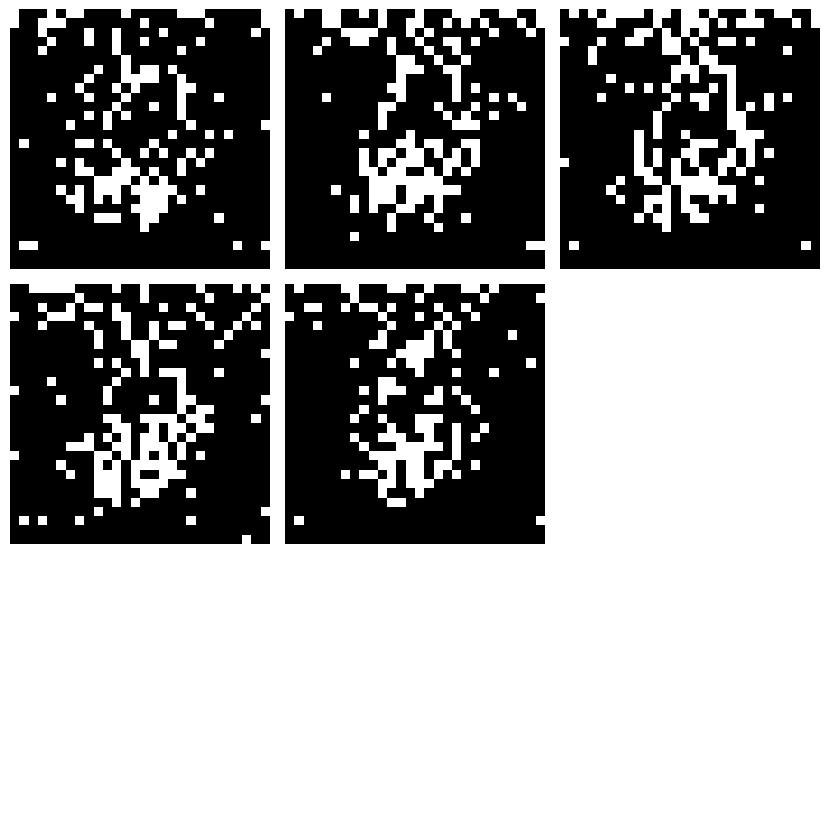

Epoch:   8/ 10, Batch     1, Loss: 0.3412
Epoch:   8/ 10, Batch   101, Loss: 0.3410
Epoch:   8/ 10, Batch   201, Loss: 0.3400
Epoch:   8/ 10, Batch   301, Loss: 0.3382
Epoch:   8/ 10, Batch   401, Loss: 0.3368
Epoch:   8/ 10, Batch   501, Loss: 0.3344
Epoch:   8/ 10, Batch   601, Loss: 0.3320
Epoch:   8/ 10, Batch   701, Loss: 0.3308
Epoch:   8/ 10, Batch   801, Loss: 0.3275
Epoch:   8/ 10, Batch   901, Loss: 0.3269
-----------------------------------------
Epoch:   8 took 9.97s
Epoch:   8, Test Loss: 0.3226
-----------------------------------------
tensor([[0.4958, 0.4933, 0.4951,  ..., 0.0301, 0.0242, 0.0288],
        [0.4958, 0.4952, 0.4979,  ..., 0.0263, 0.0279, 0.0237],
        [0.4958, 0.4937, 0.4955,  ..., 0.0309, 0.0269, 0.0342],
        ...,
        [0.4958, 0.4942, 0.4967,  ..., 0.0284, 0.0187, 0.0266],
        [0.4958, 0.4953, 0.4979,  ..., 0.0119, 0.0108, 0.0099],
        [0.4958, 0.4953, 0.4948,  ..., 0.0689, 0.0318, 0.0478]],
       device='cuda:0', grad_fn=<SigmoidBackwa

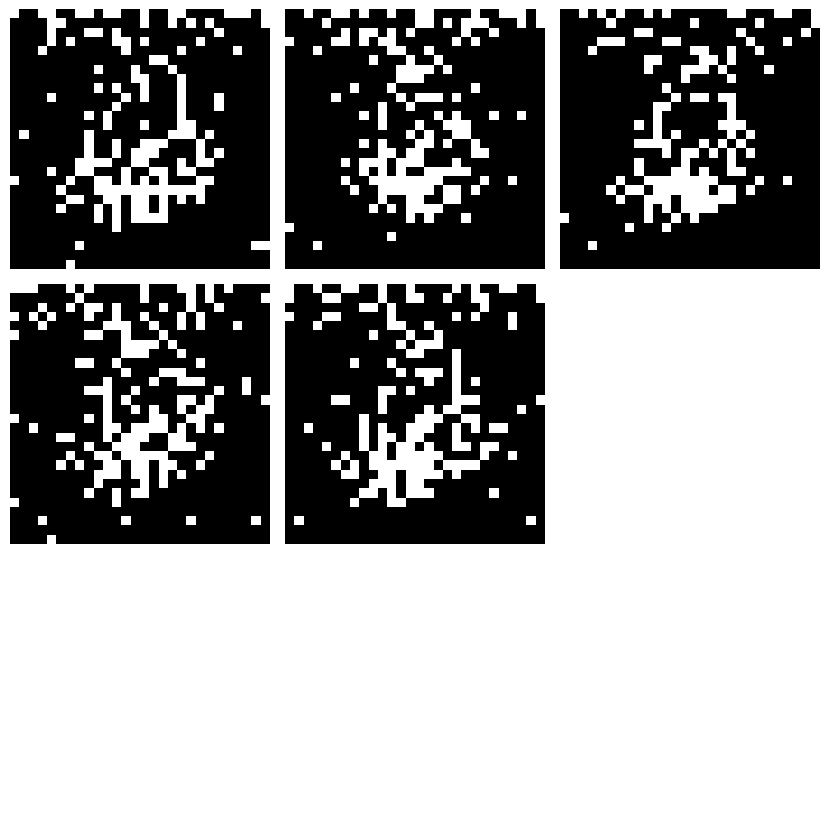

Epoch:   9/ 10, Batch     1, Loss: 0.3211
Epoch:   9/ 10, Batch   101, Loss: 0.3241
Epoch:   9/ 10, Batch   201, Loss: 0.3230
Epoch:   9/ 10, Batch   301, Loss: 0.3204
Epoch:   9/ 10, Batch   401, Loss: 0.3187
Epoch:   9/ 10, Batch   501, Loss: 0.3182
Epoch:   9/ 10, Batch   601, Loss: 0.3163
Epoch:   9/ 10, Batch   701, Loss: 0.3143
Epoch:   9/ 10, Batch   801, Loss: 0.3127
Epoch:   9/ 10, Batch   901, Loss: 0.3102
-----------------------------------------
Epoch:   9 took 10.00s
Epoch:   9, Test Loss: 0.3070
-----------------------------------------
tensor([[0.4956, 0.4947, 0.4953,  ..., 0.0102, 0.0124, 0.0168],
        [0.4956, 0.4946, 0.4983,  ..., 0.0139, 0.0130, 0.0147],
        [0.4956, 0.4948, 0.4961,  ..., 0.0145, 0.0103, 0.0112],
        ...,
        [0.4956, 0.4951, 0.4995,  ..., 0.0152, 0.0139, 0.0090],
        [0.4956, 0.4950, 0.4956,  ..., 0.0173, 0.0223, 0.0135],
        [0.4956, 0.4951, 0.4996,  ..., 0.0351, 0.0139, 0.0248]],
       device='cuda:0', grad_fn=<SigmoidBackw

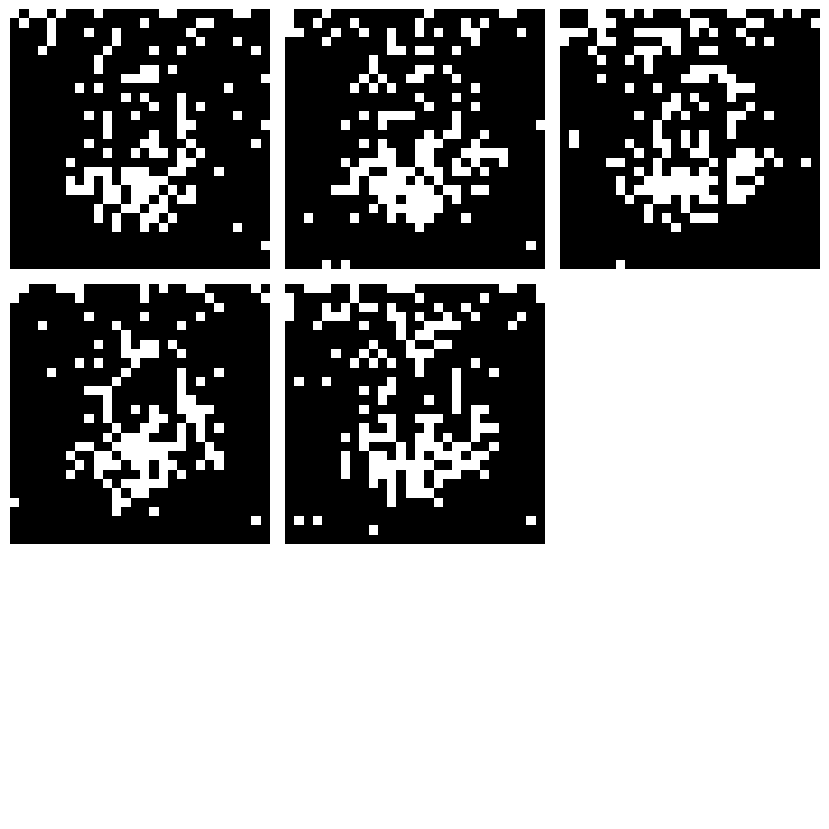

Epoch:  10/ 10, Batch     1, Loss: 0.3020
Epoch:  10/ 10, Batch   101, Loss: 0.3097
Epoch:  10/ 10, Batch   201, Loss: 0.3076
Epoch:  10/ 10, Batch   301, Loss: 0.3054
Epoch:  10/ 10, Batch   401, Loss: 0.3051
Epoch:  10/ 10, Batch   501, Loss: 0.3026
Epoch:  10/ 10, Batch   601, Loss: 0.3015
Epoch:  10/ 10, Batch   701, Loss: 0.3001
Epoch:  10/ 10, Batch   801, Loss: 0.2982
Epoch:  10/ 10, Batch   901, Loss: 0.2978
-----------------------------------------
Epoch:  10 took 10.04s
Epoch:  10, Test Loss: 0.2946
-----------------------------------------
tensor([[0.4953, 0.4949, 0.4993,  ..., 0.0135, 0.0146, 0.0123],
        [0.4953, 0.4949, 0.4993,  ..., 0.0101, 0.0115, 0.0088],
        [0.4953, 0.4939, 0.4973,  ..., 0.0049, 0.0047, 0.0066],
        ...,
        [0.4953, 0.4949, 0.4943,  ..., 0.0300, 0.0305, 0.0151],
        [0.4953, 0.4949, 0.4924,  ..., 0.0090, 0.0096, 0.0069],
        [0.4953, 0.4949, 0.4962,  ..., 0.0155, 0.0167, 0.0229]],
       device='cuda:0', grad_fn=<SigmoidBackw

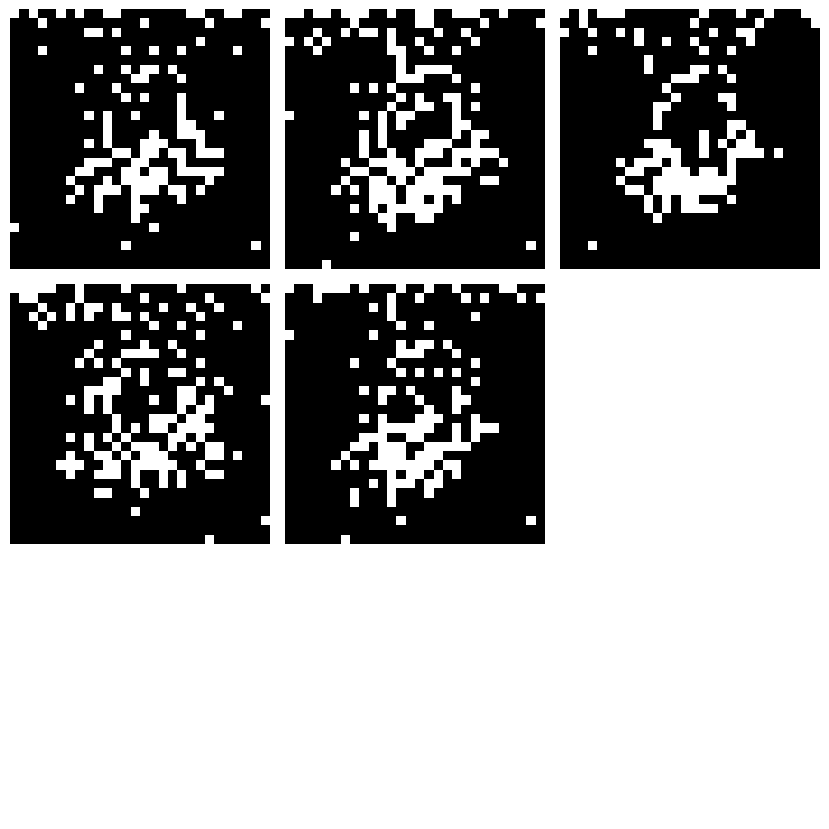

Training took 120.22s


In [14]:
import time
# Training
MADE = networks.MADE(num_layer=num_layer, num_units=num_units, ordering=ordering, input_feat=28*28)

# Select device
if torch.cuda.is_available():
  device = torch.device('cuda:0')
else:
  device = torch.device('cpu')
print(f'Using device: {device}')
print('=========================================')

MADE.to(device)

loss_curve = []
accuracy_curve = []
epoch_markers = []
optimizer= torch.optim.Adam(MADE.parameters(),lr)

overall_start_time = time.time()

for epoch in range(num_epochs):

  epoch_start_time = time.time()
  # Switch to training mode.
  MADE.train()

  losses = []
  batch_idx = 0

  for images, labels in training_data:

    images = images.to(device)

    # TODO Write your code here.

    output = MADE(images)
    loss = nn.functional.binary_cross_entropy(output,images)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()


    losses.append(loss.detach().clone())

    if batch_idx % 100 == 0:
      average_loss = torch.stack(losses).mean().item()
      loss_curve.append(average_loss)
      losses = []
      print(f'Epoch: {epoch + 1:3d}/{num_epochs:3d}, Batch {batch_idx + 1:5d}, Loss: {average_loss:.4f}')
    batch_idx += 1

  epoch_end_time = time.time()
  print('-----------------------------------------')
  print(f'Epoch: {epoch + 1:3d} took {epoch_end_time - epoch_start_time:.2f}s')
  print(f'Epoch: {epoch + 1:3d}, Test Loss: {evaluation.evaluate(model = MADE,test_data_loader = test_data, device = device):.4f}')
  print('-----------------------------------------')
  print(output)

  samples = sampling.sample(MADE, num_samples=5)
  sampling.save_samples(samples)

  

overall_end_time = time.time()
print('=========================================')
print(f'Training took {overall_end_time - overall_start_time:.2f}s')

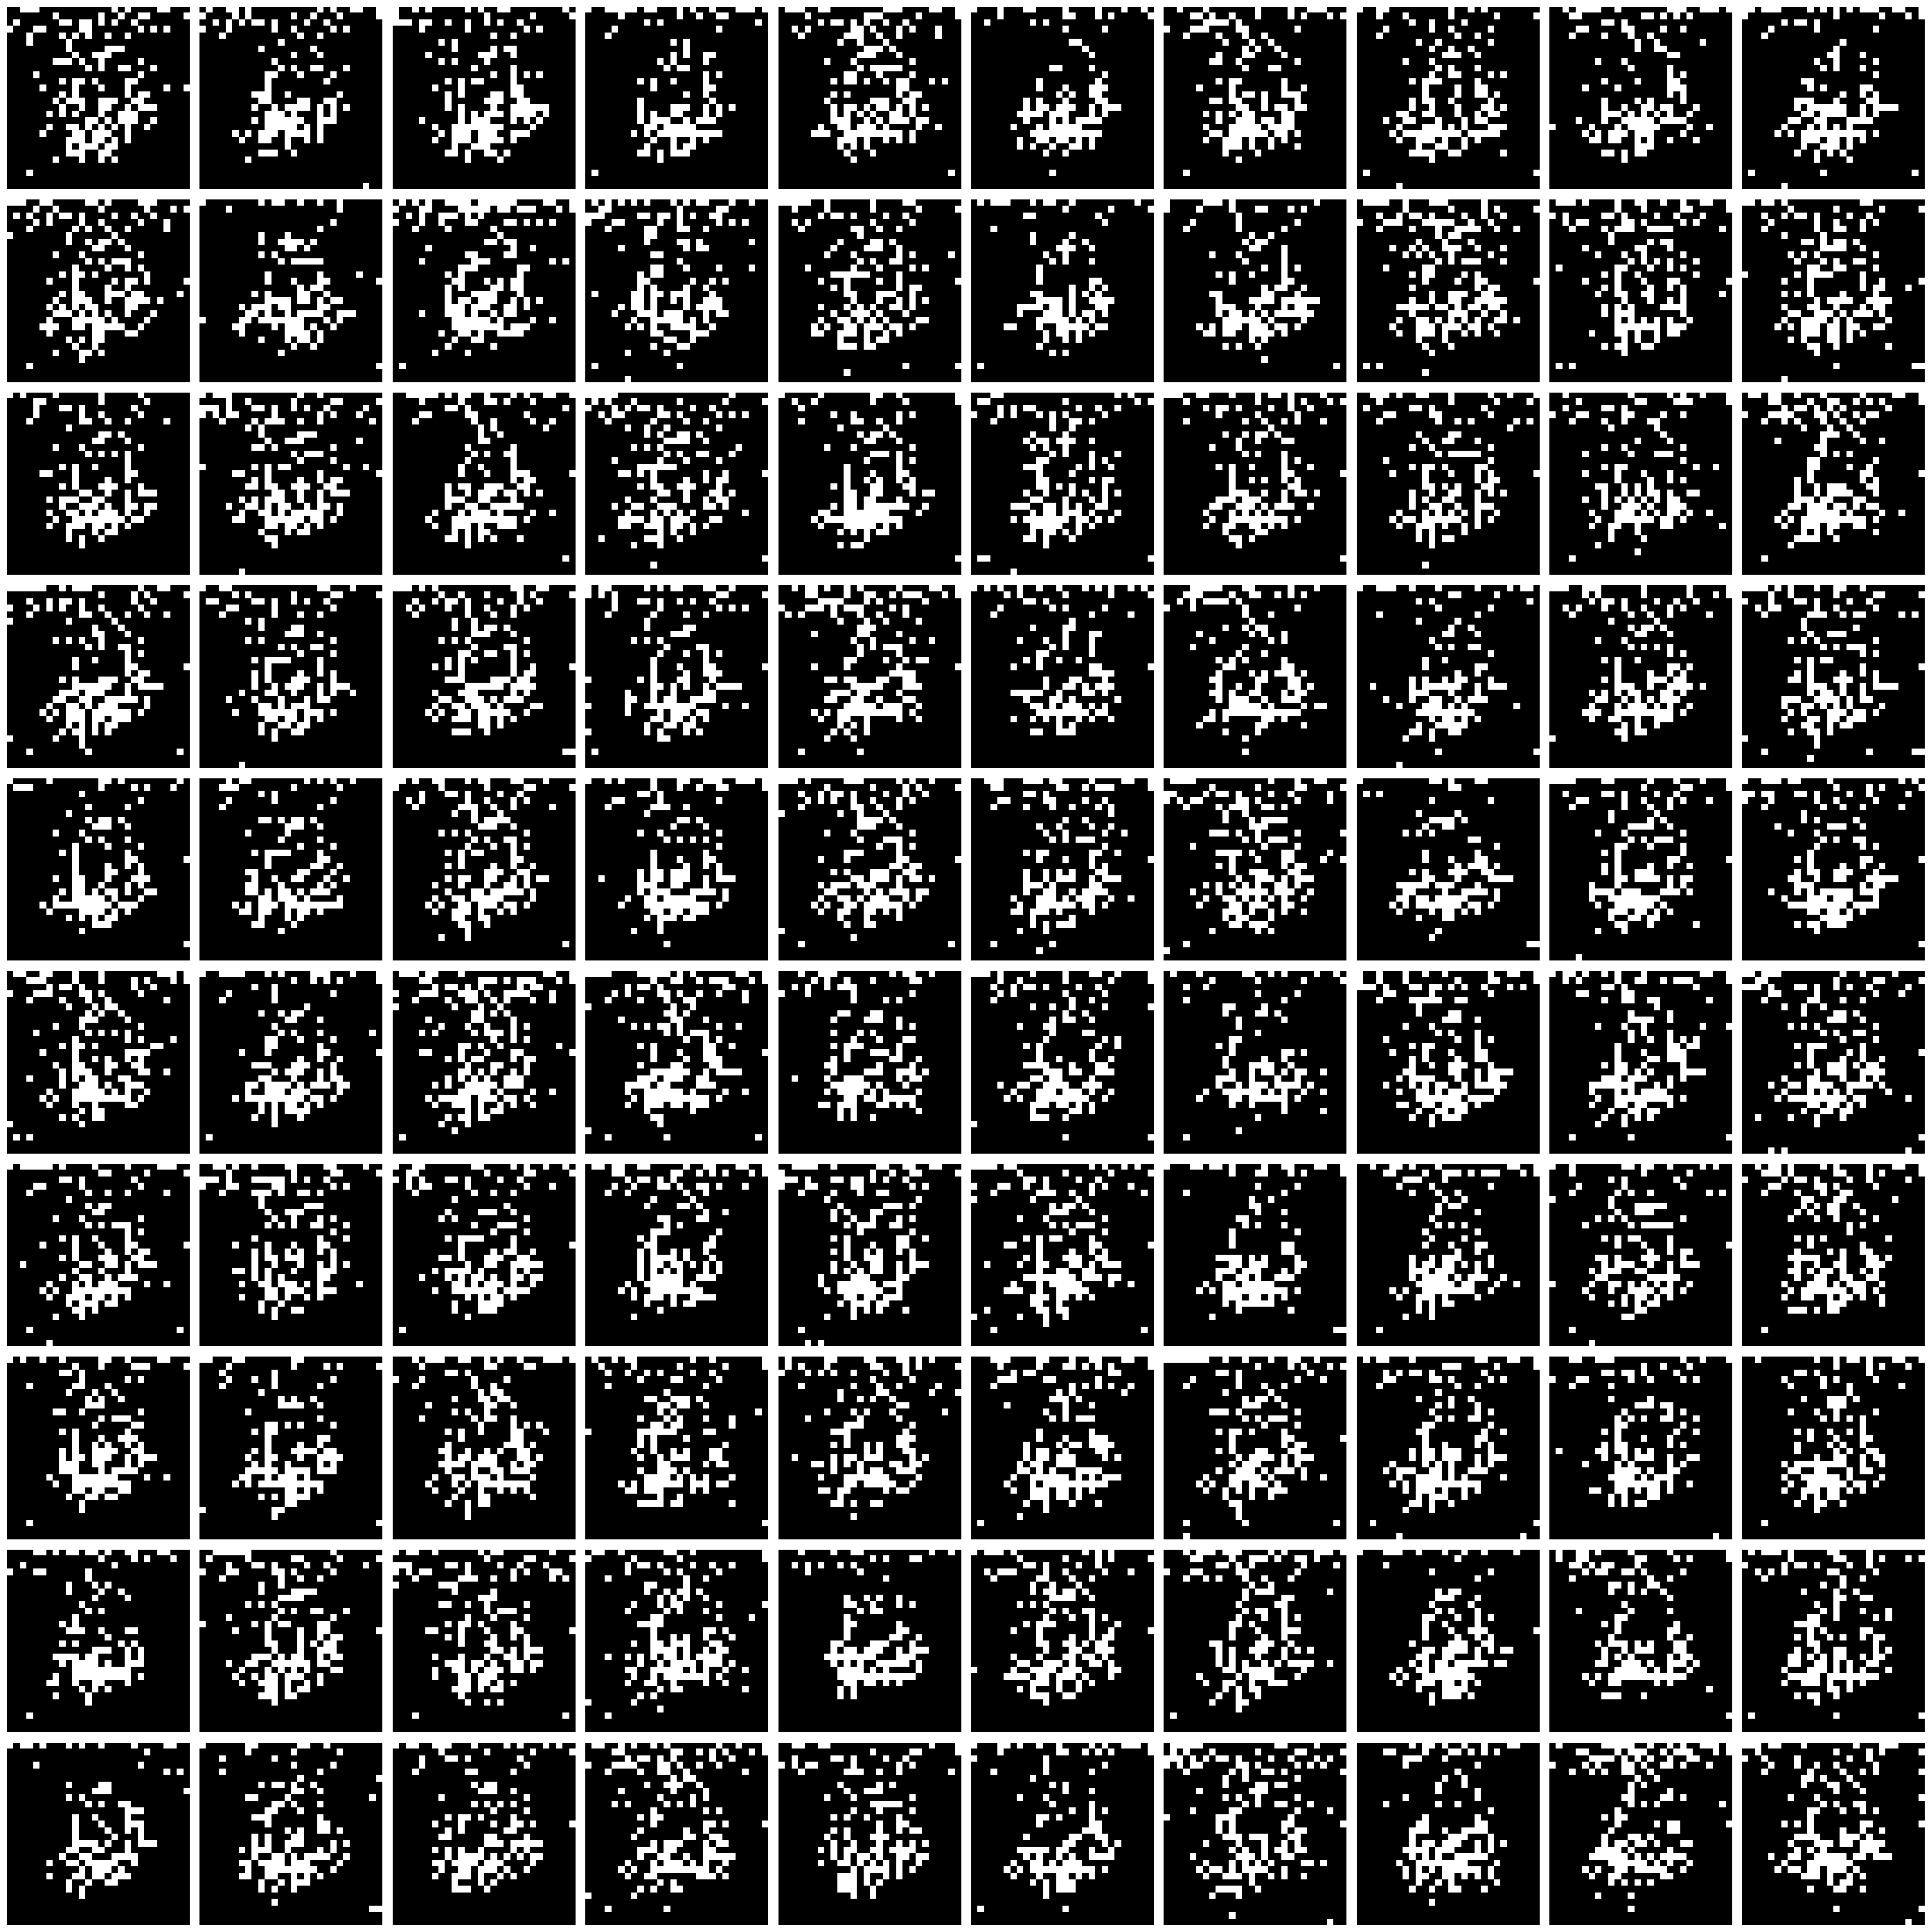

In [15]:
final_samples= sampling.sample(MADE, num_samples=100)
sampling.save_samples(final_samples)